# Bootstrapping

Bootstrapping can be used to estimate uncertainties in any kind of statistic by recalculating it repeatedly with the input data set resampled each time (with replacement, meaning [2, 7, 8, 4, 11] could become [7, 11, 11, 4, 2]). This approach is often used (a) when the method for directly calculating the uncertainty is too complicated or unknown, or (b) the sample size is very small, so it is desirable to assess the "uncertainty on the uncertainty."

In what follows we will see bootstrapping used to measure (i) the uncertainty in a correlation test result, (ii) the uncertainty in the standard deviation of a very small data set, and (iii) the uncertainty in a fitted parameter. In general, cases (i) and (ii) represent situations in which use of bootstrapping is potentially desirable, whereas case (iii) represents a situation in which standard numerical fitting will usually be superior.

This tutorial draws on the [Statistics, Data Mining, and Machine Learning](http://www.astroml.org/book_figures_1ed/index.html) textbook (which you don't have access to currently) and corresponding [astroML](http://www.astroml.org) package of Željko Ivezić, Andrew Connolly, Jacob Vanderplas, and Alex Gray. It also draws on the "smoothed bootstrap" technique of [Hesterberg (2004)](https://github.com/galastrostats/general/blob/master/JSM04-bootknife.pdf).

Author: Sheila Kannappan (with prior contributions from Rohan Isaac)<br>
Last Modified: February 2020

## Setup

If you're looking at this notebook, you've presumably already followed these instructions. Please take a moment to complete any that you have not yet finished.

 * go to https://jupyter.org/try
 * click "Try JupyterLab"
 * close open tabs in the Lab (not necessary, just less confusing)
 * open a terminal in the Lab (File>New>Terminal)
 * paste the following into the terminal to get the jupyter notebook:<br/>
  `wget https://raw.githubusercontent.com/capprogram/bootstrapping/master/bootstrapping.ipynb -P /home/jovyan/demo`
 * type the following into the terminal to get the astroML package:<br/> 
  `pip install astroML`
 * if necessary, click the refresh page (curled arrow) at the top of the webpage
 * you can run or re-run individual cells in the notebook by clicking on them and typing Ctrl-Enter

In [1]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
import scipy.stats as stats     # statistical functions

# ipython "magic" to enable static plot output directly to notebook
%matplotlib inline

## Part I. Uncertainties on Correlation Tests and Basics of Bootstrapping Methodology
As described [here](http://www.astroml.org/book_figures_1ed/chapter3/fig_correlations.html#book-fig-chapter3-fig-correlations), the figure below shows bootstrap estimates of the distribution of Pearson’s, Spearman’s, and Kendall’s correlation coefficients based on 2000 bootstrap resamplings of a fixed set of 1000 covariant bivariate Gaussian data points contaminated by 10 outliers. The true correlation coefficients for the underlying covariant bivariate Gaussian distribution are shown by the dashed lines. It is clear that Pearson’s correlation coefficient is not robust to contamination.
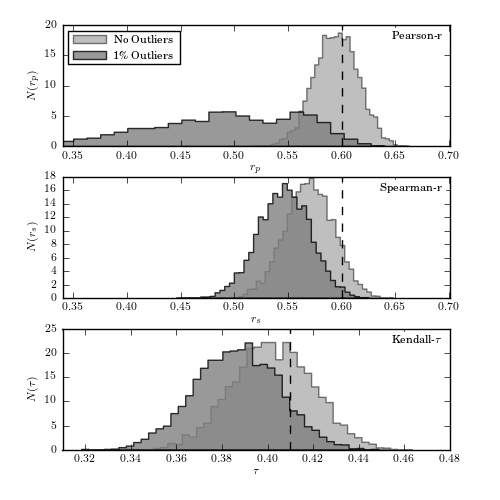

To understand the algorithm underlying the bootstrap, we reproduce the code below (slightly modified from the astroML version for pedagogical purposes, and limited to 500 bootstrap resamplings). Notice the use of check_random_state to generate one random number seed for the entire suite of resamplings.

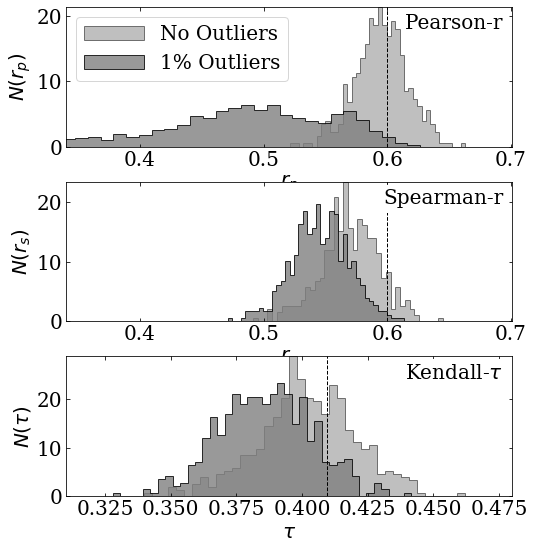

In [4]:
"""
Correlation estimates
---------------------
Figure 3.24.
Bootstrap estimates of the distribution of Pearson's, Spearman's, and Kendall's
correlation coefficients based on 500 resamplings of the 1000 points shown
in figure 3.23. The true values are shown by the dashed lines. It is clear
that Pearson's correlation coefficient is not robust to contamination.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#
# Modified by Sheila Kannappan for pedagogical purposes

from astroML.stats.random import bivariate_normal
from astroML.utils import check_random_state

def bootstrap_correln_results(xydata, Nbootstraps, random_state=None):
    xdata=xydata[:,0]
    ydata=xydata[:,1]
    Ndata=len(xdata)
    Ntests=3
    results = np.zeros((Ntests, Nbootstraps))
    rng = check_random_state(random_state)
    ind = rng.randint(Ndata, size=(Ndata,Nbootstraps))
    for k in range(Nbootstraps):
        for i, statistic in enumerate([stats.pearsonr,
                                       stats.spearmanr,
                                       stats.kendalltau]):
            results[i, k] = statistic(xdata[ind[:,k]], ydata[ind[:,k]])[0]
    return results

#----------------------------------------------------------------------
# This function adjusts matplotlib settings.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=False)

#------------------------------------------------------------
# Set parameters for the distributions
Nbootstraps = 500
Npts = 1000

sigma1 = 2.0
sigma2 = 1.0
mu = (10.0, 10.0)
alpha_deg = 45.0
alpha = alpha_deg * np.pi / 180
fracout = 0.01 # fraction of points to be made into outliers
sigmaout1 = 2.
sigmaout2 = 5.
alphaout = alpha

#------------------------------------------------------------
# sample the distribution
# without outliers and with outliers
np.random.seed(0)
dataXY = bivariate_normal(mu, sigma1, sigma2, alpha, Npts)

dataXY_out = dataXY.copy()
dataXY_out[:int(fracout * Npts)] = bivariate_normal(mu, sigmaout1, sigmaout2,
                                      alphaout, int(fracout * Npts))

# true values of rho (pearson/spearman r) and tau
# tau value comes from Eq. 41 of arXiv:1011.2009 (paper ID, just paste into google)
rho_true = 0.6
tau_true = 2 / np.pi * np.arcsin(rho_true)


#------------------------------------------------------------
# Use the bootstrap_correln_results function to compute the statistics.  

results = bootstrap_correln_results(dataXY, Nbootstraps)
results_out = bootstrap_correln_results(dataXY_out, Nbootstraps)

#------------------------------------------------------------
# Plot the results in a three-panel plot
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(bottom=0.1, top=0.95, hspace=0.25)

histargs = dict(alpha=0.5, label='No Outliers')
histargs_out = dict(alpha=0.8, label='%i%% Outliers' % (int(fracout * 100)))

distributions = ['Pearson-r', 'Spearman-r', r'Kendall-$\tau$']
Ntests=3
xlabels = ['r_p', 'r_s', r'\tau']\

for i in range(Ntests):
    ax = fig.add_subplot(311 + i)
    ax.hist(results[i], 40, histtype='stepfilled', fc='gray',
               density=True, **histargs)
    ax.hist(results_out[i], 40, histtype='stepfilled', fc='gray',
               density=True, **histargs_out)

    if i == 0:
        ax.legend(loc=2)

    ylim = ax.get_ylim()
    if i < 2:
        ax.plot([rho_true, rho_true], ylim, '--k', lw=1)
        ax.set_xlim(0.34, 0.701)
    else:
        ax.plot([tau_true, tau_true], ylim, '--k', lw=1)
        ax.set_xlim(0.31, 0.48)
    ax.set_ylim(ylim)

    ax.text(0.98, 0.95, distributions[i], ha='right', va='top',
            transform=ax.transAxes, bbox=dict(fc='w', ec='w'))

    ax.set_xlabel('$%s$' % xlabels[i])
    ax.set_ylabel('$N(%s)$' % xlabels[i])

plt.show()

The distributions above confirm that a statistical test result always has its own uncertainty, which may be substantial. In this case, the Kendall tau probably offers the best combination of unbiased median result and robustness to outliers.

Bootstrapping is obviously slow and should be vectorized whenever possible. Why is it not possible to vectorize the *bootstrap_correln_results* function above?

Hint: there is a helper function called [astroML.resample.bootstrap](https://www.astroml.org/modules/generated/astroML.resample.bootstrap.html) that can perform bootstraps for a user-supplied function, but the stats package functions pearsonr, spearmanr, and kendalltau won't work with it. Why not?

## Part II. The Smoothed Bootstrap, or, How to Bootstrap Small Data Sets

What if instead of 1000 data points to resample from, you had only 5?

Below we construct an initial random sample of 5 points drawn from a Gaussian with mean = 0 and &sigma; = 1. We compare the directly computed &sigma; for this sample from `np.std` to the input ("true") &sigma; as well as to the &sigma; found using `astroML.resample.bootstrap` with `np.std`.

GOTCHA: You must read the documentation for `np.std` to set the parameter ddof properly -- the default value is not the preferred one! It is also important to specify an axis for np.std, because np.std flattens arrays by default.

Bootstrapping outputs an entire distribution of values (one for each bootstrap iteration) so you can think of the median value as the &sigma; estimate and the 16th and 84th percentiles as bounding the 68% confidence interval. 

Below we perform 500 runs with 5 different starting data points each time, and we perform 1000 bootstrap resamples of the 5 data points within each run.

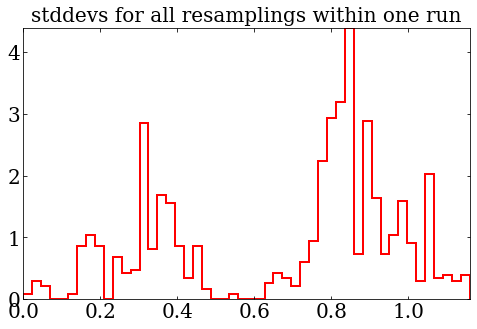

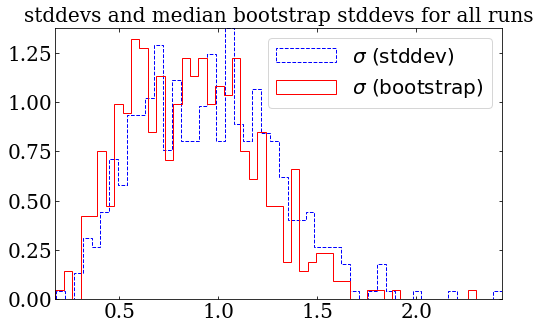

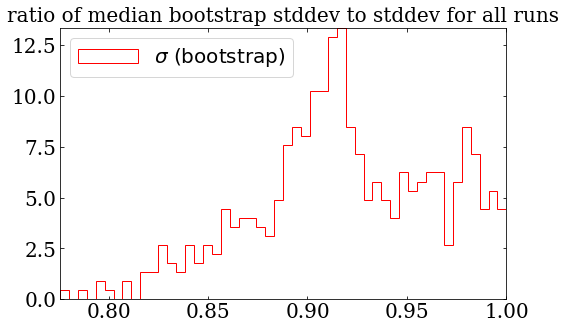

In [7]:
import astroML.resample as mlre # machine learning for astronomy
Ndata=5
Nbootstrap=1000

truemean = 0.
truesigma = 1.

nruns = 500
sigstddev = np.zeros(nruns)
sigboot = np.zeros(nruns)
for irun in range(nruns):
    np.random.seed()
    data = stats.norm(truemean, truesigma).rvs(Ndata)
    sigstddev[irun] = np.std(data,ddof=1)
    sigstddevboot = mlre.bootstrap(data, Nbootstrap,  np.std, kwargs=dict(axis=1, ddof=1))
    sigboot[irun] = np.median(sigstddevboot)
#    code here in loop looks at all bootstrap results for a single run (single data set)
    if irun == 7: # choose 7 as an example run for no particular reason
        fig0, ax0 = plt.subplots(figsize=(8, 5))
        ax0.hist(sigstddevboot, bins=50, density=True, histtype='step',
           color='red', lw=2, label=r'$\sigma\ {\rm (bootstrap)}$')
        ax0.set_title("stddevs for all resamplings within one run")

# code below looks at the median bootstrap results for all nruns data sets (one median per run)
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(sigstddev, bins=50, density=True, histtype='step',
        color='blue', ls='dashed', label=r'$\sigma\ {\rm (stddev)}$')
ax.hist(sigboot, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma\ {\rm (bootstrap)}$')
ax.set_title("stddevs and median bootstrap stddevs for all runs")
ax.legend()

fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.hist(sigboot/sigstddev, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma\ {\rm (bootstrap)}$')
ax2.set_title("ratio of median bootstrap stddev to stddev for all runs")
ax2.legend(loc='upper left')

The above histograms show how the 1000 bootstrapped values from np.std vary within one run and how the median values vary over the 500 runs. If you rerun the code, you can see how much the results vary.

Now let's try the "smoothed bootstrap" of [Hesterberg (2004)](https://github.com/galastrostats/general/blob/master/JSM04-bootknife.pdf), which was designed to handle the situation in which you have very few data points. First take a look at the smoothed bootstrap code below, which implements the algorithm in the article.

In [8]:
"""
Smoothed Bootstrap Function
Author: Sheila Kannappan
adapted from astroML.resample.bootstrap September 2016
"""

from astroML.utils import check_random_state

def smoothedbootstrap(data, n_bootstraps, user_statistic, kwargs=None,
              random_state=None):
    """Compute smoothed bootstrapped statistics of a data set.
    Parameters
    ----------
    data : array_like
        A 1-dimensional data array of size n_samples
    n_bootstraps : integer
        the number of bootstrap samples to compute.  Note that internally,
        two arrays of size (n_bootstraps, n_samples) will be allocated.
        For very large numbers of bootstraps, this can cause memory issues.
    user_statistic : function
        The statistic to be computed.  This should take an array of data
        of size (n_bootstraps, n_samples) and return the row-wise statistics
        of the data.
    kwargs : dictionary (optional)
        A dictionary of keyword arguments to be passed to the
        user_statistic function.
    random_state: RandomState or an int seed (0 by default)
        A random number generator instance
    Returns
    -------
    distribution : ndarray
        the bootstrapped distribution of statistics (length = n_bootstraps)
    """
    # we don't set kwargs={} by default in the argument list, because using
    # a mutable type as a default argument can lead to strange results
    if kwargs is None:
        kwargs = {}

    rng = check_random_state(random_state)

    data = np.asarray(data)
    n_datapts = data.size

    if data.ndim != 1:
        raise ValueError("bootstrap expects 1-dimensional data")

    # Generate random indices with repetition
    ind = rng.randint(n_datapts, size=(n_bootstraps, n_datapts))
    
    # smoothing noise
    noisemean = 0.
    noisesigma = np.std(data,ddof=1) / np.sqrt(n_datapts)
    noise = npr.normal(noisemean,noisesigma,(n_bootstraps, n_datapts))
    databroadcast = data[ind] + noise

    # Call the function
    stat_bootstrap = user_statistic(databroadcast, **kwargs)

    # compute the statistic on the data
    return stat_bootstrap

The key addition in the code above is the "smoothing noise", with amplitude of order the estimated error in the mean.

Here's the same code we had above, just adding in the above smoothed bootstrap for comparison.

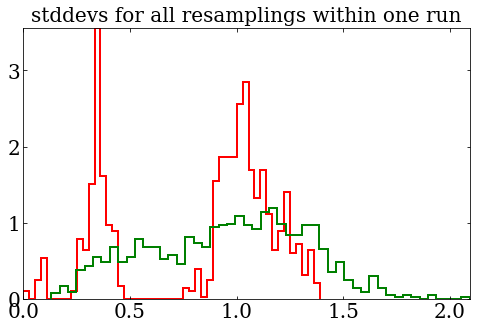

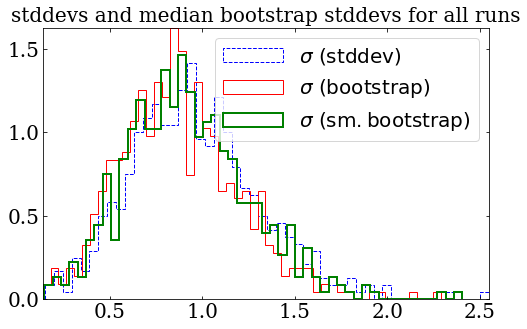

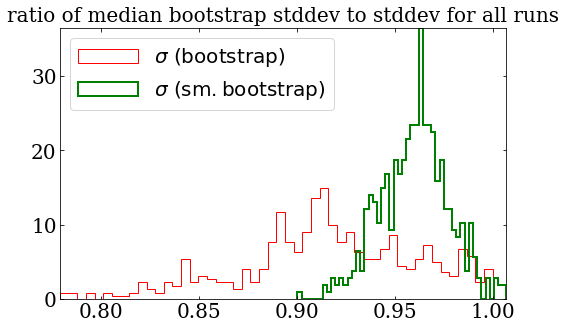

In [9]:
Ndata=5
Nbootstrap=1000

truemean = 0.
truesigma = 1.

nruns = 500
sigstddev = np.zeros(nruns)
sigboot = np.zeros(nruns)
sigsmboot = np.zeros(nruns)

for irun in range(nruns):
    np.random.seed()
    data = stats.norm(truemean, truesigma).rvs(Ndata)
    sigstddev[irun] = np.std(data,ddof=1)
    sigstddevboot = mlre.bootstrap(data, Nbootstrap,  np.std, kwargs=dict(axis=1, ddof=1))
    sigboot[irun] = np.median(sigstddevboot)
    sigstddevsmboot = smoothedbootstrap(data, Nbootstrap,  np.std, kwargs=dict(axis=1, ddof=1))
    sigsmboot[irun] = np.median(sigstddevsmboot)
#    code here in loop looks at all bootstrap results for a single run (single data set)
    if irun == 7: # choose 7 as an example run for no particular reason
        fig0, ax0 = plt.subplots(figsize=(8, 5))
        ax0.hist(sigstddevboot, bins=50, density=True, histtype='step',
           color='red', lw=2, label=r'$\sigma\ {\rm (bootstrap)}$')
        ax0.hist(sigstddevsmboot, bins=50, density=True, histtype='step',
            color='green', lw=2, label=r'$\sigma\ {\rm (sm. bootstrap)}$')
        ax0.set_title("stddevs for all resamplings within one run")

# code below looks at the median bootstrap results for all nruns data sets (one median per run)
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(sigstddev, bins=50, density=True, histtype='step',
        color='blue', ls='dashed', label=r'$\sigma\ {\rm (stddev)}$')
ax.hist(sigboot, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma\ {\rm (bootstrap)}$')
ax.hist(sigsmboot, bins=50, density=True, histtype='step',
        color='green', lw=2, label=r'$\sigma\ {\rm (sm. bootstrap)}$')
ax.set_title("stddevs and median bootstrap stddevs for all runs")
ax.legend()

fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.hist(sigboot/sigstddev, bins=50, density=True, histtype='step',
        color='red', label=r'$\sigma\ {\rm (bootstrap)}$')
ax2.hist(sigsmboot/sigstddev, bins=50, density=True, histtype='step',
        color='green', lw=2, label=r'$\sigma\ {\rm (sm. bootstrap)}$')
ax2.set_title("ratio of median bootstrap stddev to stddev for all runs")
ax2.legend(loc='upper left')

Magic! Although still biased slightly low, the smoothed bootstrap is much better behaved than the bootstrap for small N.

## Part III. Bootstrapping to Estimate Uncertainties in Fitted Parameters

Below we revisit the code from our [basic fitting tutorial](https://github.com/capprogram/2021bootcamp/tree/master/fitting-basic), in which we performed parameter estimation by maximum likelihood fitting and computed errors on the slope and intercept of a line fit using both a pure analytic solution and a numerical estimate based on the Hessian matrix. Here we augment the code to obtain bootstrap estimates of the slope and intercept uncertainties and compare with the analytic and numerical results.

Running this code repeatedly to generate different data sets reveals that the bootstrap uncertainties are less reliable than the analytic and Hessian-derived uncertainties, but still perform surprisingly well, even with only 50 data points to resample.

analytic slope is 1.9990860 +- 0.0237224
analytic intercept is 5.2039150 +- 0.6950695
numerical slope is 1.9990860 +- 0.0237224
numerical intercept is 5.2039150 +- 0.6950695
               
bootstrap slope is 1.9991780 + 0.0219987 - 0.0220093
bootstrap intercept is 5.2098943 + 0.6849424 - 0.6769556
slope error ratio: 0.92756
int error ratio: 0.97968


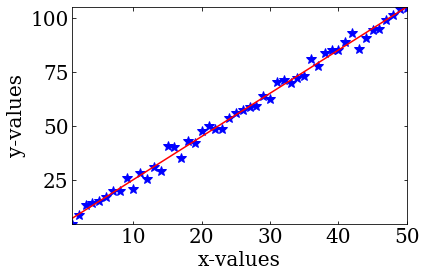

In [10]:
"""
Code for Tutorial on Parameter Estimation by Maximum Likelihood Fitting
Modified by Kathleen Eckert from an activity written by Sheila Kannappan
++version with BOOTSTRAPPING added by Sheila Kannappan June 2017
"""

from astroML.utils import check_random_state

# Generating fake data set to start with:
alphatrue=2. # slope
betatrue=5.  # intercept
errs=2.5 # sigma (amplitude of errors)

narr=50 # number of data points
xvals = np.arange(narr) + 1. # xvals range from 1-51
yvals = alphatrue*xvals + betatrue + npr.normal(0,errs,narr) # yvals 

# Plot fake data
plt.figure(1) 
plt.clf()
plt.plot(xvals,yvals,'b*',markersize=10)
plt.xlabel("x-values")
plt.ylabel("y-values")

# Determine slope & y-intercept using least squares analytic solution 

alphaest=(np.mean(xvals)*np.mean(yvals)-np.mean(xvals*yvals)) / \
   (np.mean(xvals)**2 -np.mean(xvals**2)) #  from derivation
betaest= np.mean(yvals) - alphaest * np.mean(xvals) # calculate estimate of y-intercept from derivation

# Overplot the MLE ("best fit") solution
yfitvals=xvals*alphaest+betaest
plt.plot(xvals,yfitvals,'r')

# Compute analytic uncertainties on slope and y-intercept 

alphaunc = np.sqrt(np.sum((yvals - (alphaest*xvals+betaest))**2) / ((narr-2.)*(np.sum((xvals-np.mean(xvals))**2))))
betaunc = np.sqrt((np.sum((yvals - (alphaest*xvals+betaest))**2) / (narr-2.)) * ((1./narr) + (np.mean(xvals)**2)/np.sum((xvals-np.mean(xvals))**2)) )

print("analytic slope is %0.7f +- %0.7f" % (alphaest,alphaunc))
print("analytic intercept is %0.7f +- %0.7f" % (betaest,betaunc))

# Solution using python solver np.polyfit
# third parameter is order of fit, 1 for linear
pfit = np.polyfit(xvals, yvals, 1) # returns coeff. of highest order term first

# Can also obtain parameter uncertainties from the diagonal terms of the covariance
# matrix, which is the inverse of the Hessian matrix and
# can be computed in np.polyfit by setting cov='True'

pfit,covp = np.polyfit(xvals, yvals, 1, cov='True') # returns coeff. of highest power first
# setting cov='True' returns the covariance matrix
print("numerical slope is %0.7f +- %0.7f" % (pfit[0], np.sqrt(covp[0,0])))
print("numerical intercept is %0.7f +- %0.7f" % (pfit[1], np.sqrt(covp[1,1])))

# BOOTSTRAP!

npars = 2 # slope and intercept
nboot = 10000 # usually want at least 1000
rng = check_random_state(None)
ind = rng.randint(narr, size=(narr,nboot))
bootresults = np.zeros((npars,nboot))
for iboot in range(nboot):
    bootresults[:,iboot] = np.polyfit(xvals[ind[:,iboot]], yvals[ind[:,iboot]], 1)
sloperesults = bootresults[0,:]
intresults = bootresults[1,:]
slopesort = np.argsort(sloperesults)
slopemed = np.median(sloperesults)
pct16 = int(round(0.16*nboot))
pct84 = int(round(0.84*nboot))
slope68pcterrs = [slopemed-sloperesults[slopesort[pct16]],sloperesults[slopesort[pct84]]-slopemed]
intsort = np.argsort(intresults)
intmed = np.median(intresults)
int68pcterrs = [intmed-intresults[intsort[pct16]],intresults[intsort[pct84]]-intmed]

print("               ") # put in some whitespace to make easier to read
print("bootstrap slope is %0.7f + %0.7f - %0.7f" % (slopemed,slope68pcterrs[0],slope68pcterrs[1]))
print("bootstrap intercept is %0.7f + %0.7f - %0.7f" % (intmed,int68pcterrs[0],int68pcterrs[1]))
print("slope error ratio: %0.5f" % (0.5*(np.sum(slope68pcterrs))/np.sqrt(covp[0,0])))
print("int error ratio: %0.5f" % (0.5*(np.sum(int68pcterrs))/np.sqrt(covp[1,1])))

## Would we really bootstrap a line fit?

Usually, we bootstrap when there is no easy way to calculate uncertainties by simpler analytic or numerical means. So line fitting will not normally call for bootstrapping -- it just offers a nice comparative test of the method. Less deterministic numerical methods, e.g., machine learning or optimization by simulated annealing, are better candidates for bootstrapping.